Đang chạy thử nghiệm 25 cấu hình tham số...
Hoàn thành trong 16.41s

>>> KẾT QUẢ TỐI ƯU NHẤT:
Tham số: h = 5.0, k = 0.001
PSNR đạt được: 21.85 dB


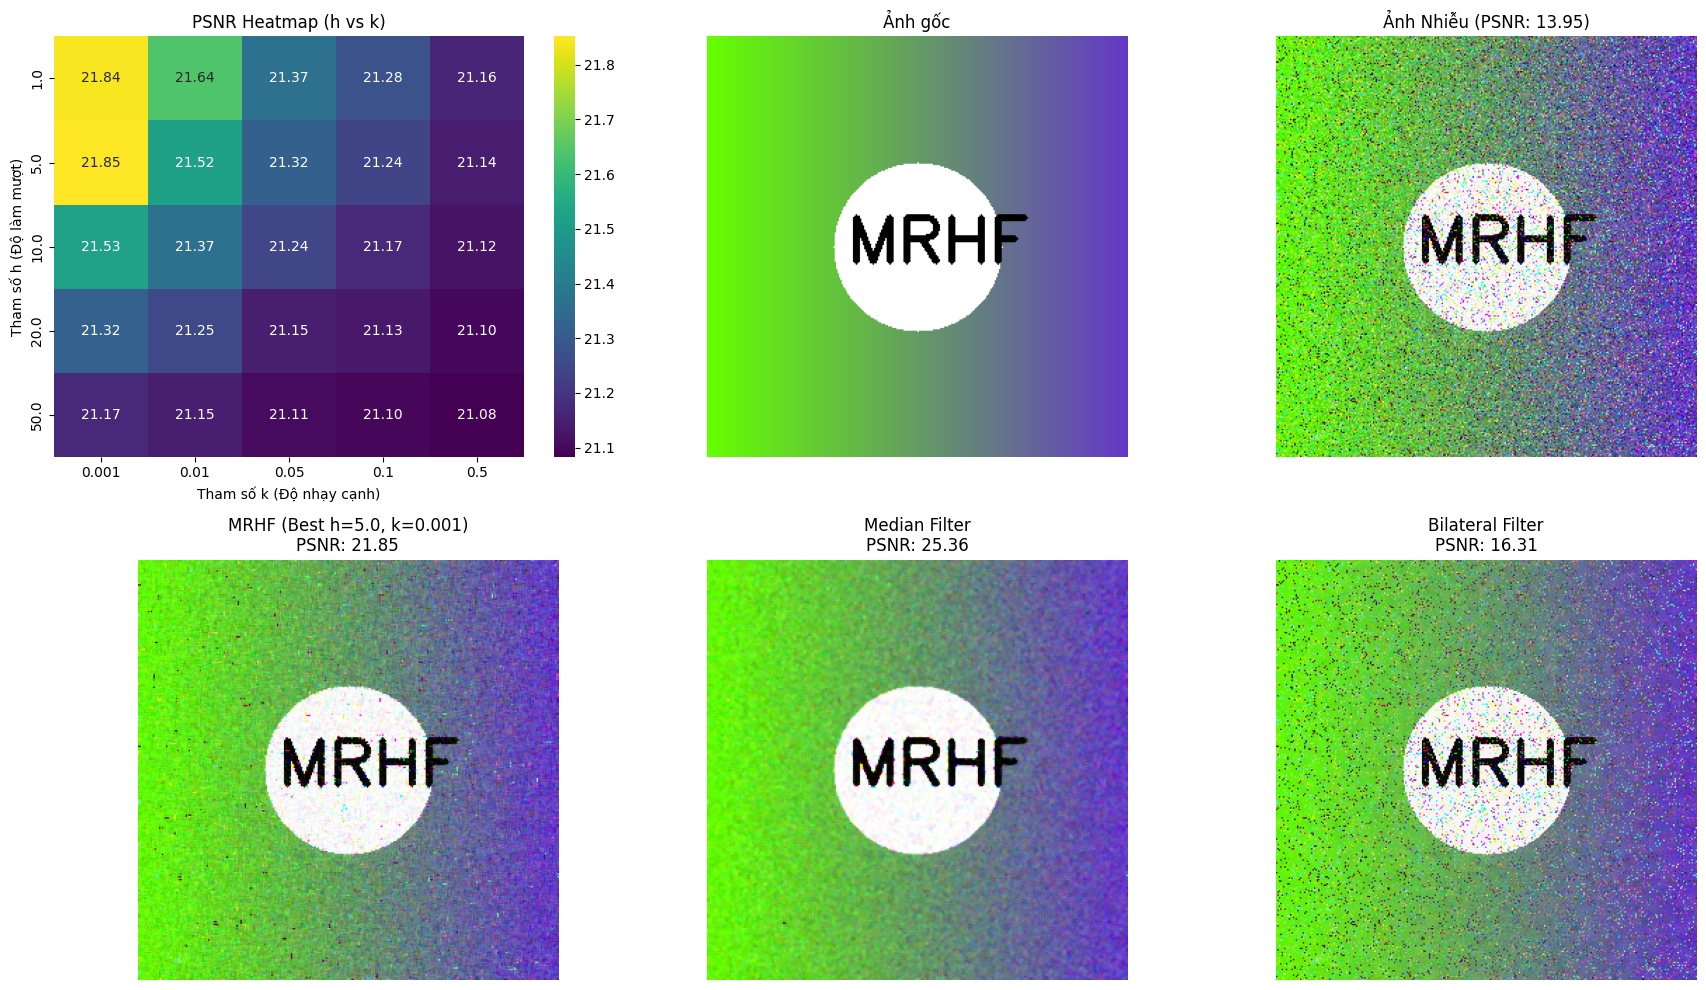

In [1]:
# ============================
# 1. CÀI ĐẶT THƯ VIỆN & IMPORTS
# ============================
!pip install --quiet scikit-image numba opencv-python matplotlib seaborn

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from numba import njit, prange
import warnings

warnings.filterwarnings('ignore')

# ============================
# 2. CÁC HÀM TIỆN ÍCH
# ============================
def add_mixed_noise(image, gauss_sigma=20, impulse_prob=0.1):
    """Thêm nhiễu hỗn hợp: Gaussian nặng + Muối tiêu"""
    noisy = image.astype(np.float32)

    # 1. Nhiễu Gaussian
    gauss = np.random.normal(0, gauss_sigma, image.shape)
    noisy = noisy + gauss

    # 2. Nhiễu Muối tiêu (Impulse)
    # Xử lý cho cả ảnh màu và ảnh xám
    if image.ndim == 3:
        H, W, C = image.shape
        mask = np.random.rand(H, W) # Mask chung cho pixel vị trí đó
        # Tuy nhiên, nhiễu thường độc lập trên các kênh, nhưng muối tiêu thường bị cả pixel
        # Ở đây ta giả lập nhiễu độc lập trên từng kênh
        rnd = np.random.rand(H, W, C)
        noisy[rnd < (impulse_prob/2)] = 0
        noisy[rnd > 1 - (impulse_prob/2)] = 255
    else:
        rnd = np.random.rand(*image.shape)
        noisy[rnd < (impulse_prob/2)] = 0
        noisy[rnd > 1 - (impulse_prob/2)] = 255

    return np.clip(noisy, 0, 255).astype(np.uint8)

def compute_metrics(ref, dist):
    """Tính PSNR và SSIM an toàn"""
    # Chuyển về Gray để tính SSIM chính xác hơn cho đánh giá cấu trúc
    if ref.ndim == 3:
        ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
        dist_gray = cv2.cvtColor(dist, cv2.COLOR_BGR2GRAY)
    else:
        ref_gray, dist_gray = ref, dist

    p = psnr(ref, dist, data_range=255)
    s = ssim(ref_gray, dist_gray, data_range=255)
    return p, s

# ============================
# 3. CORE THUẬT TOÁN MRHF (NUMBA)
# ============================
@njit(parallel=True, fastmath=True)
def mrhf_core_numba(pad_img, h, k, H, W):
    """
    Cài đặt MRHF2 (Unidirectional) tối ưu tốc độ.
    Sử dụng cửa sổ 5x5 mở rộng để khử nhiễu tốt hơn như đề xuất trong phần mở rộng bài báo.
    """
    out = np.empty((H, W), dtype=np.uint8)

    # Duyệt song song từng pixel
    for i in prange(H):
        for j in range(W):
            r, c = i + 2, j + 2 # Tọa độ trên ảnh đã padding

            # --- 1. Phi2: Center Weighted Median (CWMF) ---
            # Plus-shaped mask trong vùng 5x5
            # Center (r,c) được lặp lại 5 lần (trọng số 5)
            # Các điểm lân cận theo hình dấu cộng (+)

            # Khởi tạo mảng tĩnh để Numba tối ưu (13 phần tử: 8 hàng xóm + 5 center)
            arr_phi2 = np.empty(13, dtype=np.float32)

            arr_phi2[0] = pad_img[r-2, c] # Top-Top
            arr_phi2[1] = pad_img[r-1, c] # Top
            arr_phi2[2] = pad_img[r+1, c] # Bottom
            arr_phi2[3] = pad_img[r+2, c] # Bottom-Bottom

            arr_phi2[4] = pad_img[r, c-2] # Left-Left
            arr_phi2[5] = pad_img[r, c-1] # Left
            arr_phi2[6] = pad_img[r, c+1] # Right
            arr_phi2[7] = pad_img[r, c+2] # Right-Right

            center_val = pad_img[r, c]
            for x in range(5):
                arr_phi2[8+x] = center_val

            # Sắp xếp tìm trung vị
            # Với mảng 13 phần tử, trung vị là phần tử thứ 6 (index 6) sau khi sort
            arr_phi2.sort()
            phi2 = arr_phi2[6]

            # --- 2. Phi1 (Ngang) & Phi3 (Dọc) ---
            # Unidirectional Median filter (size 3)

            # Phi1: Ngang
            p1_arr = np.empty(3, dtype=np.float32)
            p1_arr[0] = pad_img[r, c-1]
            p1_arr[1] = center_val
            p1_arr[2] = pad_img[r, c+1]
            p1_arr.sort()
            phi1 = p1_arr[1]

            # Phi3: Dọc
            p3_arr = np.empty(3, dtype=np.float32)
            p3_arr[0] = pad_img[r-1, c]
            p3_arr[1] = center_val
            p3_arr[2] = pad_img[r+1, c]
            p3_arr.sort()
            phi3 = p3_arr[1]

            # --- 3. Rational Function ---
            numerator = phi1 - 2.0*phi2 + phi3
            edge_sensor = (phi1 - phi3)**2

            # Mẫu số: h + k * edge_sensor
            denominator = h + k * edge_sensor + 1e-8

            val = phi2 + numerator / denominator

            # Clip kết quả
            if val < 0: val = 0
            if val > 255: val = 255
            out[i, j] = int(val + 0.5)

    return out

def run_mrhf(image, h, k):
    """Wrapper function để xử lý ảnh màu hoặc xám"""
    img_in = image.astype(np.float32)
    H, W = img_in.shape[:2]

    # Padding
    if image.ndim == 3:
        out = np.zeros_like(image)
        for ch in range(3):
            pad = cv2.copyMakeBorder(img_in[:,:,ch], 2, 2, 2, 2, cv2.BORDER_REFLECT)
            out[:,:,ch] = mrhf_core_numba(pad, h, k, H, W)
        return out
    else:
        pad = cv2.copyMakeBorder(img_in, 2, 2, 2, 2, cv2.BORDER_REFLECT)
        return mrhf_core_numba(pad, h, k, H, W)

# ============================
# 4. MODULE THỬ NGHIỆM THAM SỐ (GRID SEARCH)
# ============================
def grid_search_parameters(noisy_img, clean_img, h_list, k_list):
    print(f"Đang chạy thử nghiệm {len(h_list) * len(k_list)} cấu hình tham số...")

    best_psnr = 0
    best_params = (0, 0)
    results = np.zeros((len(h_list), len(k_list)))

    start_total = time.time()

    for i, h in enumerate(h_list):
        for j, k in enumerate(k_list):
            # Chạy bộ lọc
            denoised = run_mrhf(noisy_img, h, k)

            # Tính điểm
            score, _ = compute_metrics(clean_img, denoised)
            results[i, j] = score

            if score > best_psnr:
                best_psnr = score
                best_params = (h, k)

            # print(f"  > h={h}, k={k} -> PSNR: {score:.2f}")

    print(f"Hoàn thành trong {time.time() - start_total:.2f}s")
    return results, best_params, best_psnr

# ============================
# 5. CHẠY CHƯƠNG TRÌNH CHÍNH
# ============================

# --- A. Tạo dữ liệu ---
def create_test_image():
    H, W = 300, 300
    img = np.zeros((H,W,3), dtype=np.uint8)
    for i in range(W):
        img[:,i] = [i*200//W, 255-i*200//W, 100] # Gradient
    cv2.circle(img, (150,150), 60, (255,255,255), -1) # Vật thể cạnh sắc
    cv2.putText(img, "MRHF", (100,160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 3)
    return img

clean_img = create_test_image()
# Nhiễu khá nặng để test sức mạnh bộ lọc (Sigma=25, Impulse=10%)
noisy_img = add_mixed_noise(clean_img, gauss_sigma=25, impulse_prob=0.1)

# --- B. Thử nghiệm tìm tham số tối ưu ---
# Định nghĩa khoảng tham số cần test
h_values = [1.0, 5.0, 10.0, 20.0, 50.0]
k_values = [0.001, 0.01, 0.05, 0.1, 0.5]

psnr_matrix, best_params, best_score = grid_search_parameters(noisy_img, clean_img, h_values, k_values)

print(f"\n>>> KẾT QUẢ TỐI ƯU NHẤT:")
print(f"Tham số: h = {best_params[0]}, k = {best_params[1]}")
print(f"PSNR đạt được: {best_score:.2f} dB")

# --- C. Áp dụng tham số tốt nhất & So sánh ---
final_mrhf = run_mrhf(noisy_img, best_params[0], best_params[1])
median_opencv = cv2.medianBlur(noisy_img, 3)
bilateral = cv2.bilateralFilter(noisy_img, 9, 75, 75)

# --- D. Trực quan hóa ---
plt.figure(figsize=(18, 10))

# 1. Biểu đồ Heatmap hiệu năng tham số
plt.subplot(2, 3, 1)
sns.heatmap(psnr_matrix, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=k_values, yticklabels=h_values)
plt.title("PSNR Heatmap (h vs k)")
plt.xlabel("Tham số k (Độ nhạy cạnh)")
plt.ylabel("Tham số h (Độ làm mượt)")

# 2. Các ảnh kết quả
images = [clean_img, noisy_img, final_mrhf, median_opencv, bilateral]
titles = [
    "Ảnh gốc",
    f"Ảnh Nhiễu (PSNR: {psnr(clean_img, noisy_img):.2f})",
    f"MRHF (Best h={best_params[0]}, k={best_params[1]})\nPSNR: {best_score:.2f}",
    f"Median Filter\nPSNR: {psnr(clean_img, median_opencv):.2f}",
    f"Bilateral Filter\nPSNR: {psnr(clean_img, bilateral):.2f}"
]

for i in range(5):
    plt.subplot(2, 3, i+2)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

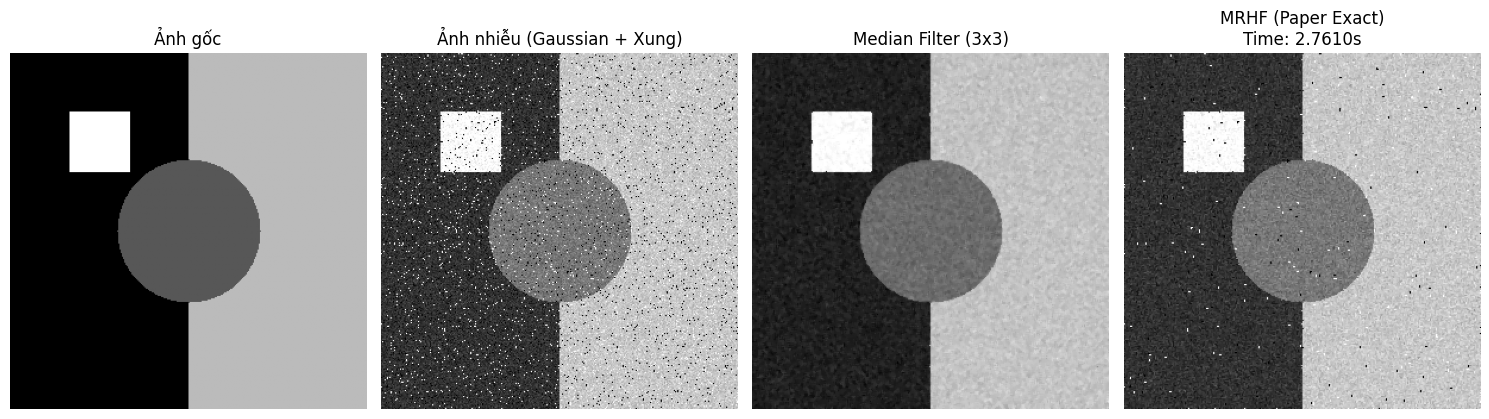

PSNR Median Filter: 31.22 dB
PSNR MRHF (Exact):  24.03 dB


In [2]:
# =============================================================================
# CÀI ĐẶT CHÍNH XÁC THEO BÀI BÁO: MEDIAN-RATIONAL HYBRID FILTERS (1998)
# Tác giả: L. Khriji & M. Gabbouj
# Biến thể cài đặt: MRHF2 (Figure 5) - Unidirectional Sub-filters
# =============================================================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
from numba import njit, prange

@njit(parallel=True, fastmath=True)
def mrhf_exact_paper_core(padded_img, h, k, height, width):
    """
    Hàm xử lý lõi (Core) sử dụng Numba để duyệt pixel tốc độ cao.

    Cấu trúc tuân thủ:
    1. Phi2: Center Weighted Median (Mask 3x3, Weight Center=3, Cross=1)
    2. Phi1: Horizontal Median (Mask 1x3)
    3. Phi3: Vertical Median (Mask 3x1)
    4. Rational Function: Eq. 1 trong bài báo
    """
    output = np.empty((height, width), dtype=np.uint8)

    for i in prange(height):
        for j in range(width):
            # Tọa độ thực trên ảnh đã padding (lệch 1 do mask 3x3)
            r, c = i + 1, j + 1

            # --- 1. TÍNH PHI_2: CENTER WEIGHTED MEDIAN (CWM) ---
            # Theo bài báo: Mask hình dấu cộng (+).
            # Pixel trung tâm lặp lại 3 lần. Các pixel N, S, E, W lặp lại 1 lần.
            # Tổng cộng mảng có: 4 (hàng xóm) + 3 (trung tâm) = 7 phần tử.

            # Lấy giá trị
            val_center = padded_img[r, c]
            val_top    = padded_img[r-1, c]
            val_bottom = padded_img[r+1, c]
            val_left   = padded_img[r, c-1]
            val_right  = padded_img[r, c+1]

            # Tạo mảng tìm trung vị (Hard-coded array cho tốc độ)
            # Mảng 7 phần tử
            arr_phi2 = np.empty(7, dtype=np.float32)
            arr_phi2[0] = val_top
            arr_phi2[1] = val_bottom
            arr_phi2[2] = val_left
            arr_phi2[3] = val_right
            arr_phi2[4] = val_center
            arr_phi2[5] = val_center
            arr_phi2[6] = val_center

            # Tìm trung vị của mảng 7 phần tử (phần tử thứ 4 sau khi sort - index 3)
            arr_phi2.sort()
            phi2 = arr_phi2[3]

            # --- 2. TÍNH PHI_1 & PHI_3: UNIDIRECTIONAL MEDIAN (MRHF2) ---
            # Dựa trên Figure 5 của bài báo:
            # Phi1: Trung vị theo chiều ngang (Horizontal)
            # Phi3: Trung vị theo chiều dọc (Vertical)

            # Phi1 (Ngang: Left, Center, Right)
            arr_h = np.empty(3, dtype=np.float32)
            arr_h[0] = val_left
            arr_h[1] = val_center
            arr_h[2] = val_right
            arr_h.sort()
            phi1 = arr_h[1] # Lấy giữa

            # Phi3 (Dọc: Top, Center, Bottom)
            arr_v = np.empty(3, dtype=np.float32)
            arr_v[0] = val_top
            arr_v[1] = val_center
            arr_v[2] = val_bottom
            arr_v.sort()
            phi3 = arr_v[1] # Lấy giữa

            # --- 3. CÔNG THỨC HỮU TỈ (RATIONAL FUNCTION - Eq. 1) ---
            # y(n) = Phi2 + (Phi1 - 2*Phi2 + Phi3) / (h + k*(Phi1 - Phi3)^2)

            numerator = phi1 - 2.0 * phi2 + phi3
            edge_sensor = (phi1 - phi3) ** 2

            # Thêm epsilon nhỏ (1e-8) để tránh lỗi chia cho 0 về mặt kỹ thuật
            denominator = h + k * edge_sensor + 1e-8

            res = phi2 + (numerator / denominator)

            # Cắt giá trị về [0, 255]
            if res < 0: res = 0
            if res > 255: res = 255
            output[i, j] = int(res + 0.5)

    return output

def mrhf_filter_exact(image, h=10.0, k=0.1):
    """
    Hàm bao (Wrapper) để xử lý ảnh đầu vào.
    """
    # Chuyển ảnh sang float
    img_in = image.astype(np.float32)
    H, W = img_in.shape[:2]

    # Padding viền 1 pixel (cho mask 3x3)
    # Sử dụng BORDER_REFLECT như thường quy trong xử lý ảnh
    if image.ndim == 3:
        # Xử lý ảnh màu: Lọc từng kênh riêng biệt
        out = np.zeros_like(image)
        for ch in range(3):
            pad = cv2.copyMakeBorder(img_in[:,:,ch], 1, 1, 1, 1, cv2.BORDER_REFLECT)
            out[:,:,ch] = mrhf_exact_paper_core(pad, h, k, H, W)
        return out
    else:
        # Xử lý ảnh xám
        pad = cv2.copyMakeBorder(img_in, 1, 1, 1, 1, cv2.BORDER_REFLECT)
        return mrhf_exact_paper_core(pad, h, k, H, W)

# =============================================================================
# PHẦN THỬ NGHIỆM (DEMO)
# =============================================================================

def add_noise_paper_style(image):
    """
    Tạo nhiễu hỗn hợp mô phỏng theo phần 'Experimental Results' của bài báo:
    Mixed Gaussian-Impulsive noise.
    """
    noisy = image.astype(np.float32)
    # 1. Nhiễu Gaussian (mô phỏng lambda=0.2 trong bài)
    gauss = np.random.normal(0, 15, image.shape)
    noisy = noisy + gauss

    # 2. Nhiễu Xung (Impulsive)
    prob = 0.05
    rnd = np.random.rand(*image.shape)
    noisy[rnd < prob/2] = 0
    noisy[rnd > 1 - prob/2] = 255

    return np.clip(noisy, 0, 255).astype(np.uint8)

# --- 1. Tạo dữ liệu ---
# Tạo ảnh mẫu đơn giản có vùng phẳng và vùng cạnh
img_clean = np.zeros((300, 300), dtype=np.uint8)
img_clean[:, :150] = 50   # Vùng tối phẳng
img_clean[:, 150:] = 200  # Vùng sáng phẳng
cv2.circle(img_clean, (150, 150), 60, 120, -1) # Vật thể tròn (Cạnh cong)
cv2.rectangle(img_clean, (50, 50), (100, 100), 255, -1) # Vật thể vuông (Cạnh thẳng)

# --- 2. Thêm nhiễu ---
img_noisy = add_noise_paper_style(img_clean)

# --- 3. Chạy bộ lọc MRHF ---
# Tham số h, k được chọn dựa trên kinh nghiệm từ bài báo (h=10, k=0.05 thường ổn)
start_time = cv2.getTickCount()
img_mrhf = mrhf_filter_exact(img_noisy, h=15.0, k=0.08)
end_time = cv2.getTickCount()
time_sec = (end_time - start_time) / cv2.getTickFrequency()

# --- 4. So sánh với Median thường (3x3) ---
img_median = cv2.medianBlur(img_noisy, 3)

# --- 5. Hiển thị ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_clean, cmap='gray')
plt.title("Ảnh gốc")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_noisy, cmap='gray')
plt.title("Ảnh nhiễu (Gaussian + Xung)")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_median, cmap='gray')
plt.title("Median Filter (3x3)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_mrhf, cmap='gray')
plt.title(f"MRHF (Paper Exact)\nTime: {time_sec:.4f}s")
plt.axis('off')

plt.tight_layout()
plt.show()

# Tính chỉ số PSNR
psnr_med = cv2.PSNR(img_clean, img_median)
psnr_mrhf = cv2.PSNR(img_clean, img_mrhf)

print(f"PSNR Median Filter: {psnr_med:.2f} dB")
print(f"PSNR MRHF (Exact):  {psnr_mrhf:.2f} dB")